In [4]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score
from yellowbrick.classifier import ConfusionMatrix
from google.colab import drive
drive.mount('/content/drive/')

def confusion_matrix(model, unique_classes, X_train, y_train, X_test, y_test):
    cm = ConfusionMatrix(model, classes=unique_classes)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    cm.poof()

def class_to_int(y_set):

    int_y_test = y_set.copy()
    int_y_test[int_y_test == ' <=50K'] = '0'
    int_y_test[int_y_test == ' >50K'] = '1'
    int_y_test = int_y_test.astype('int32')

    return int_y_test

def roc_auc_graph(model, unique_classes, X_test, y_test,k,distance):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(unique_classes)

    roc_y_test = class_to_int(y_test)

    for i in range(n_classes):
        print(model.predict_proba(X_test)[:, i])
        print((roc_y_test == i).astype(int))
        fpr[i], tpr[i], _ = roc_curve((roc_y_test == i).astype(int), model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(f'{fpr[i]} {tpr[i]}')

    # Plot ROC curves
    plt.figure(figsize=(6, 6))
    colors = ['blue', 'red']
    for i, color in enumerate(colors):
        tempclass = " <=50K" if i == 0 else "> 50K"
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {tempclass}) (area = {roc_auc[i]:.4f})')
        if k != "":
          plt.annotate(f'K={k}', xy=(0.8, 0.2), xytext=(0.8, 0.2))
          plt.annotate(f'{distance}', xy=(0.8, 0.16), xytext=(0.8, 0.16))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Display AUC values
    for i in range(n_classes):
        print(f"AUC for class {i}: {roc_auc[i]:.4f}")

    plt.show()

def scale_dataset(dataframe, oversample=False):
  # Extract features from the dataframe: all columns except the last one
  X = dataframe[dataframe.columns[:-1]].values
  # Extract target variable from the dataframe: the last column
  y = dataframe[dataframe.columns[-1]].values
  # Initialize a standard scaler object
  scaler = StandardScaler()
  # Fit the scaler to the data and transform the features to have mean=0 and std deviation=1
  X = scaler.fit_transform(X)

  # Check if oversampling is required
  if oversample:
      # Initialize a random oversampler object for handling class imbalance
      ros = RandomOverSampler()
      # Use the oversampler to balance class distribution by duplicating some minority class samples
      X, y = ros.fit_resample(X, y)

  # Combine the standardized (and optionally oversampled) features and target into one array
  data = np.hstack((X, np.reshape(y, (-1, 1))))

  # Return the combined data, the features, and the target variable
  return data, X, y

def model(x):
      return 1 / (1 + np.exp(-x))

filename = '/content/drive/MyDrive/adult.data' # update the path to the file
cols = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','Income-Class']
cols_format = {'age':'cont',
               'workclass':'discrete',
               'fnlwgt':'cont',
               'education':'discrete',
               'education-num':'cont',
               'marital-status':'discrete',
               'occupation':'discrete',
               'relationship':'discrete',
               'race':'discrete',
               'sex':'binary',
               'capital-gain':'cont',
               'capital-loss':'cont',
               'hours-per-week':'cont',
               'native-country':'discrete',
               'Income-Class':'discrete'}
df = pd.read_csv(filename, names=cols) # add the column name to the dataframe (panda)
df.head()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


0        0
1        0
2        0
3        0
4        1
        ..
48837    1
48838    0
48839    0
48840    0
48841    0
Name: sex, Length: 48842, dtype: int64
       age  fnlwgt  education-num  sex  capital-gain  capital-loss  \
0       39   77516             13    0          2174             0   
1       50   83311             13    0             0             0   
2       38  215646              9    0             0             0   
3       53  234721              7    0             0             0   
4       28  338409             13    1             0             0   
...    ...     ...            ...  ...           ...           ...   
48837   39  215419             13    1             0             0   
48838   64  321403              9    0             0             0   
48839   38  374983             13    0             0             0   
48840   44   83891             13    0          5455             0   
48841   35  182148             13    0             0             0   


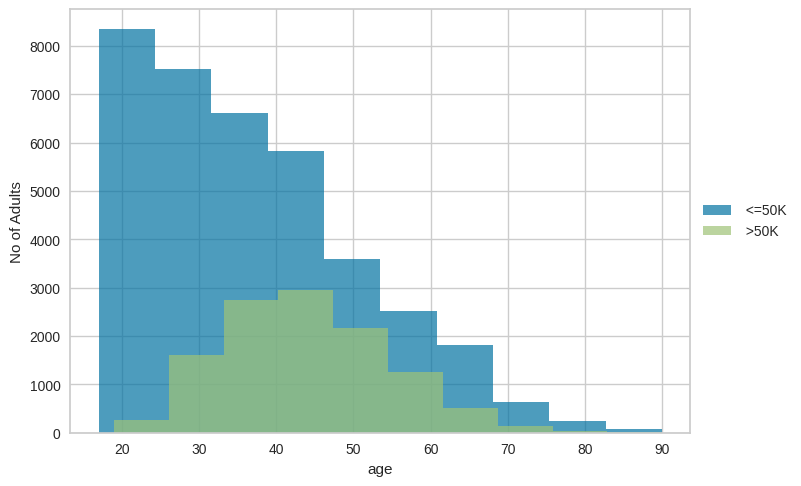

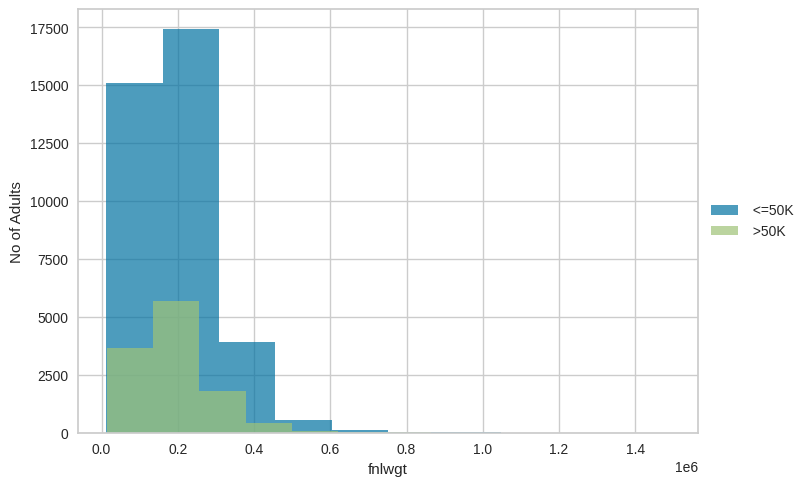

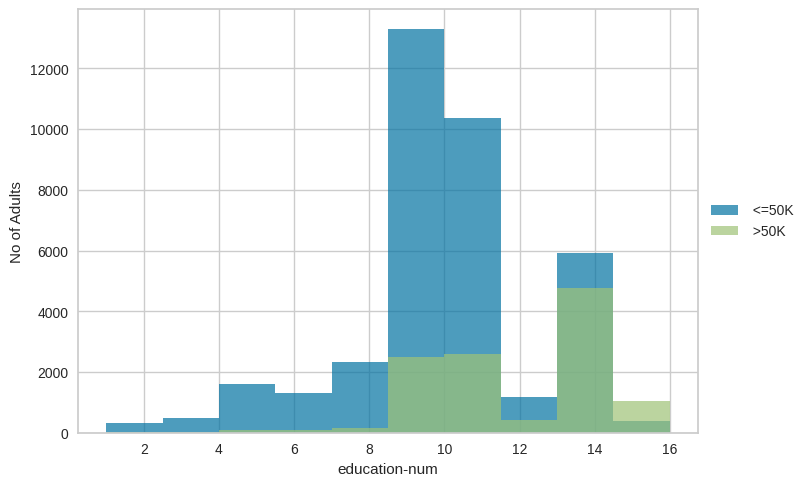

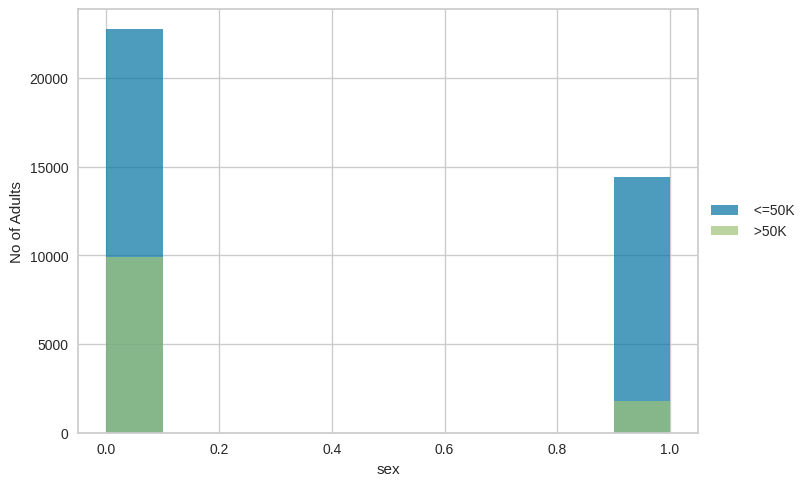

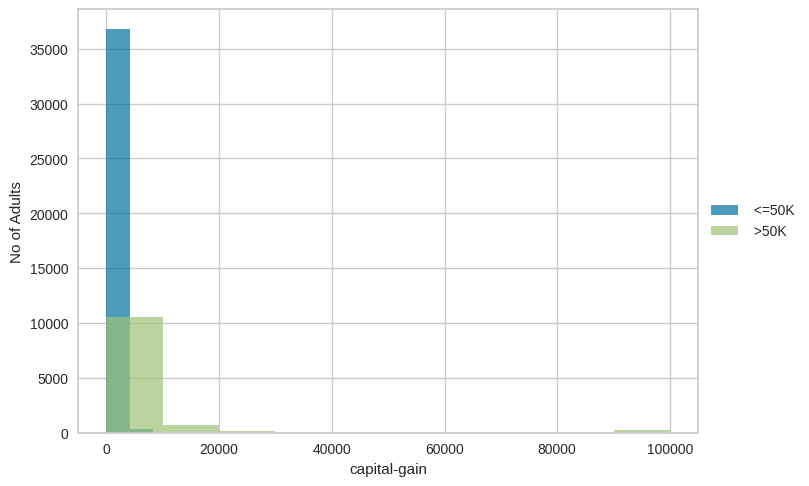

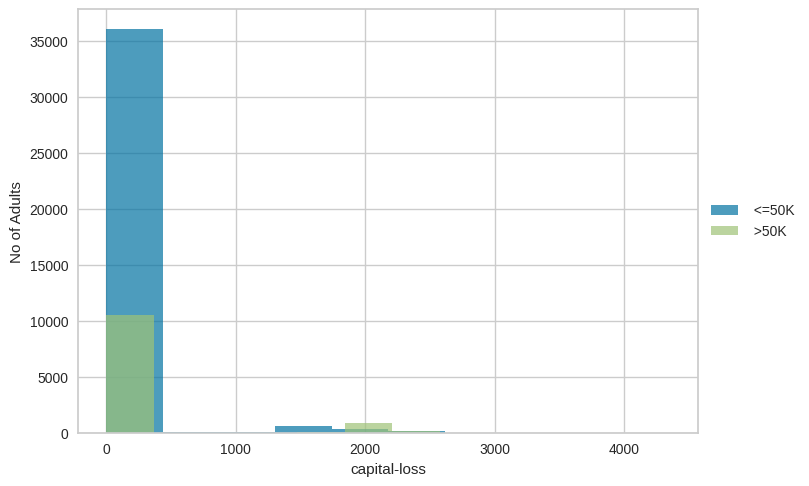

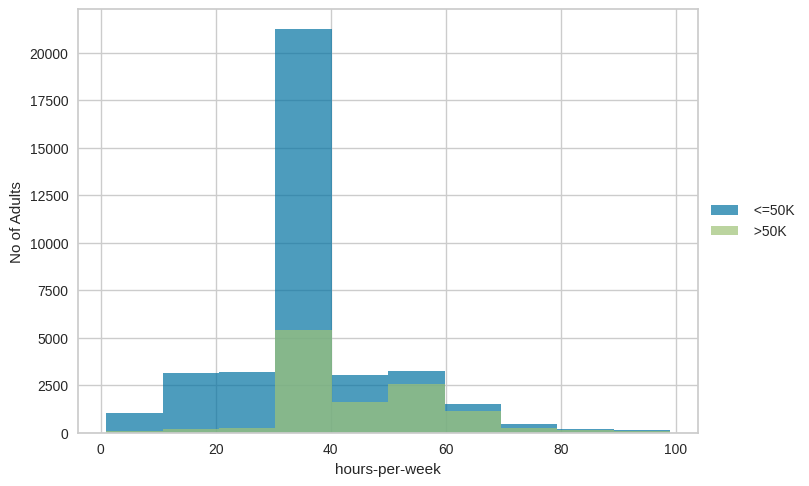

Cross-Validation Scores: [0.75657729 0.75607296 0.75840619 0.75395091 0.75596839]
Mean Cross-Validation Accuracy: 0.7562
Validation Set Accuracy:0.76
Classification Report for Validation Set:
              precision    recall  f1-score   support

       <=50K       0.90      0.77      0.83      3679
        >50K       0.51      0.74      0.60      1205

    accuracy                           0.76      4884
   macro avg       0.71      0.75      0.72      4884
weighted avg       0.80      0.76      0.77      4884

Model accuracy score: 0.7693
Classification Report for Test Set:
              precision    recall  f1-score   support

       <=50K       0.91      0.77      0.84      3735
        >50K       0.51      0.75      0.61      1150

    accuracy                           0.77      4885
   macro avg       0.71      0.76      0.72      4885
weighted avg       0.82      0.77      0.78      4885

****************Cufusion matrix of Logistic Regression for Validation Set****************

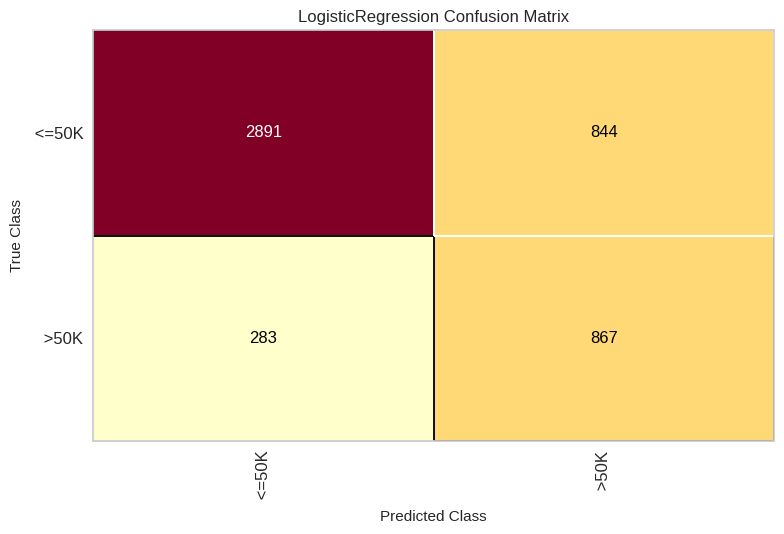

****************AUC of Logistic Regression for Validation Set***********************
[0.26256535 0.41465314 0.50983945 ... 0.07245098 0.87799636 0.14576832]
[1 0 0 ... 0 1 1]
[0.         0.         0.         ... 0.99751037 0.99917012 1.        ] [0.00000000e+00 2.71812993e-04 8.96982876e-02 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.73743465 0.58534686 0.49016055 ... 0.92754902 0.12200364 0.85423168]
[0 1 1 ... 1 0 0]
[0.         0.         0.         ... 0.91030171 0.91030171 1.        ] [0.00000000e+00 8.29875519e-04 2.48962656e-03 ... 9.99170124e-01
 1.00000000e+00 1.00000000e+00]
AUC for class 0: 0.8464
AUC for class 1: 0.8464


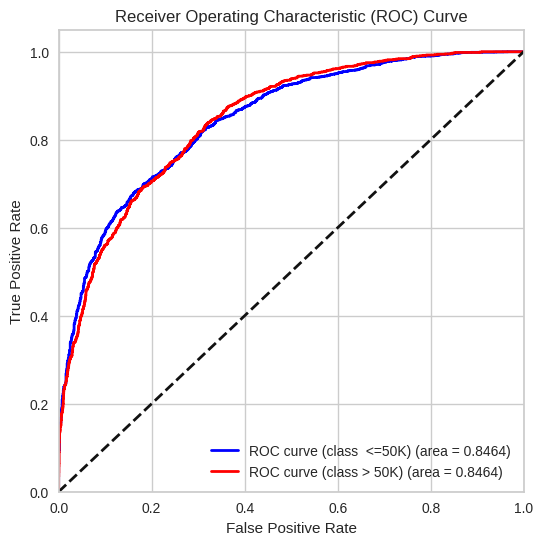

****************AUC of Logistic Regression for Testing Set***********************
[0.41829547 0.13198203 0.85579483 ... 0.07179465 0.70752157 0.29269762]
[1 0 1 ... 1 1 0]
[0.         0.         0.         ... 0.99043478 0.99826087 1.        ] [0.00000000e+00 2.67737617e-04 1.17804552e-02 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[0.58170453 0.86801797 0.14420517 ... 0.92820535 0.29247843 0.70730238]
[0 1 0 ... 0 0 1]
[0.         0.         0.         ... 0.98821954 0.98821954 1.        ] [0.00000000e+00 8.69565217e-04 1.73913043e-03 ... 9.99130435e-01
 1.00000000e+00 1.00000000e+00]
AUC for class 0: 0.8482
AUC for class 1: 0.8482


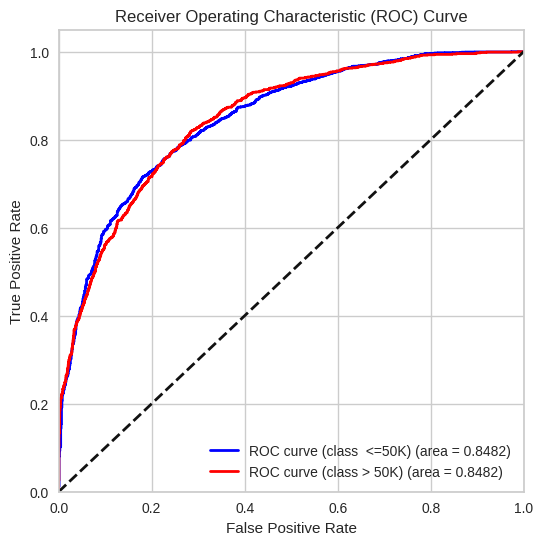

----------------------------------K=5 ------------------------------------------
****************euclidean***********************
Validation Set Accuracy:0.74
Test Set Accuracy: 0.7263
Cross-Validation Scores: [0.79583088 0.79667143 0.81329859 0.81027236 0.81094486]
Mean Cross-Validation Accuracy: 0.8054
Classification Report for Validation Set:
              precision    recall  f1-score   support

       <=50K       0.89      0.74      0.81      3679
        >50K       0.48      0.71      0.57      1205

    accuracy                           0.74      4884
   macro avg       0.68      0.73      0.69      4884
weighted avg       0.79      0.74      0.75      4884

Classification Report for Test Set:
              precision    recall  f1-score   support

       <=50K       0.89      0.73      0.80      3735
        >50K       0.45      0.71      0.55      1150

    accuracy                           0.73      4885
   macro avg       0.67      0.72      0.68      4885
weighted avg     

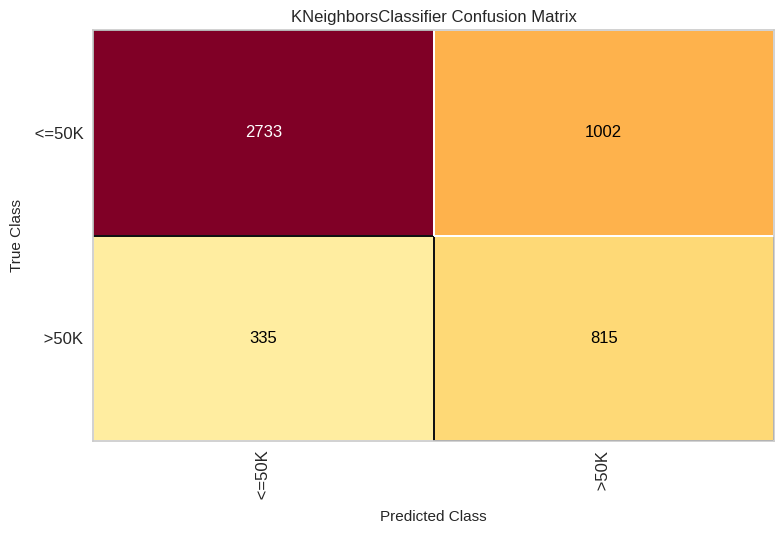

****************AUC of 5 for Validation Set***********************
[1.  0.  0.6 ... 0.  1.  0.4]
[1 0 0 ... 0 1 1]
[0.         0.13775934 0.17759336 0.2879668  0.4340249  0.62572614
 1.        ] [0.         0.59282414 0.65615656 0.74368035 0.85811362 0.9456374
 1.        ]
[0.  1.  0.4 ... 1.  0.  0.6]
[0 1 1 ... 1 0 0]
[0.         0.0543626  0.14188638 0.25631965 0.34384344 0.40717586
 1.        ] [0.         0.37427386 0.5659751  0.7120332  0.82240664 0.86224066
 1.        ]
AUC for class 0: 0.7969
AUC for class 1: 0.7969


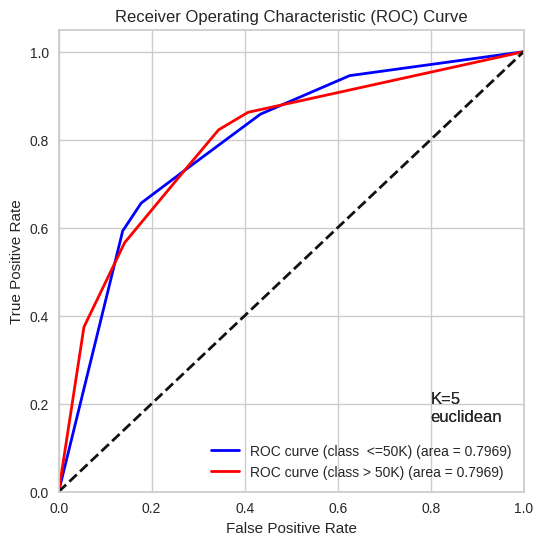

****************AUC of 5 for Testing Set***********************
[0.4 0.  0.4 ... 0.  1.  0.2]
[1 0 1 ... 1 1 0]
[0.         0.14782609 0.19913043 0.29130435 0.44521739 0.62434783
 1.        ] [0.         0.57215529 0.64364123 0.73172691 0.83908969 0.9352075
 1.        ]
[0.6 1.  0.6 ... 1.  0.  0.8]
[0 1 0 ... 0 0 1]
[0.         0.0647925  0.16091031 0.26827309 0.35635877 0.42784471
 1.        ] [0.         0.37565217 0.55478261 0.70869565 0.80086957 0.85217391
 1.        ]
AUC for class 0: 0.7801
AUC for class 1: 0.7801


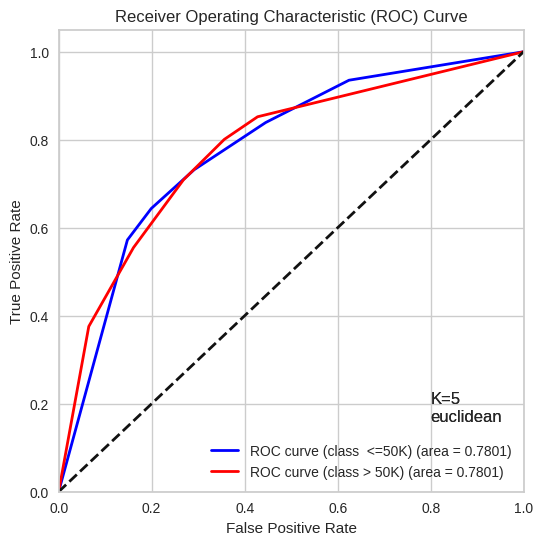

----------------------------------K=5 ------------------------------------------
****************manhattan***********************
Validation Set Accuracy:0.74
Test Set Accuracy: 0.7202
Cross-Validation Scores: [0.7961671  0.79650332 0.81346671 0.81413921 0.81279422]
Mean Cross-Validation Accuracy: 0.8066
Classification Report for Validation Set:
              precision    recall  f1-score   support

       <=50K       0.89      0.75      0.81      3679
        >50K       0.48      0.72      0.58      1205

    accuracy                           0.74      4884
   macro avg       0.69      0.73      0.69      4884
weighted avg       0.79      0.74      0.75      4884

Classification Report for Test Set:
              precision    recall  f1-score   support

       <=50K       0.89      0.72      0.80      3735
        >50K       0.44      0.71      0.54      1150

    accuracy                           0.72      4885
   macro avg       0.67      0.72      0.67      4885
weighted avg     

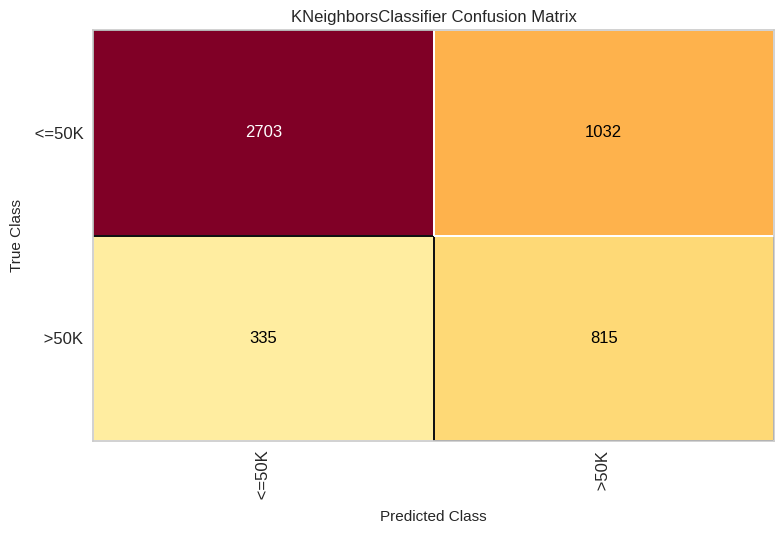

****************AUC of 5 for Validation Set***********************
[0.8 0.  1.  ... 0.  1.  0.6]
[1 0 0 ... 0 1 1]
[0.         0.14439834 0.18506224 0.27966805 0.42240664 0.62323651
 1.        ] [0.         0.59064963 0.65588475 0.74503941 0.85756999 0.94536559
 1.        ]
[0.2 1.  0.  ... 1.  0.  0.4]
[0 1 1 ... 1 0 0]
[0.         0.05463441 0.14243001 0.25496059 0.34411525 0.40935037
 1.        ] [0.         0.37676349 0.57759336 0.72033195 0.81493776 0.85560166
 1.        ]
AUC for class 0: 0.7961
AUC for class 1: 0.7961


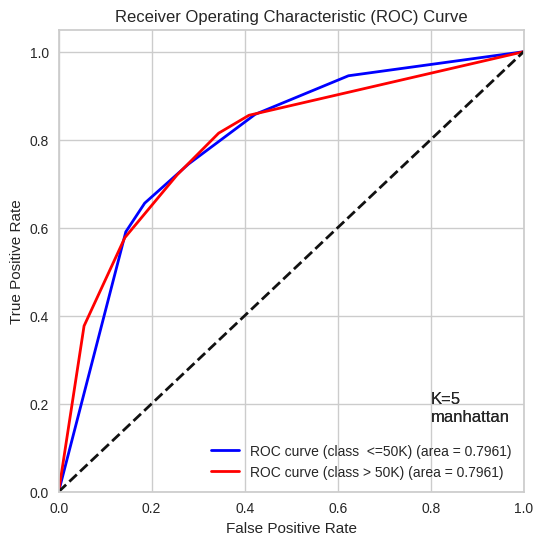

****************AUC of 5 for Testing Set***********************
[0.4 0.  0.4 ... 0.  1.  0.2]
[1 0 1 ... 1 1 0]
[0.         0.14869565 0.19913043 0.29130435 0.44521739 0.62695652
 1.        ] [0.         0.56921017 0.63801874 0.72369478 0.83882195 0.93627845
 1.        ]
[0.6 1.  0.6 ... 1.  0.  0.8]
[0 1 0 ... 0 0 1]
[0.         0.06372155 0.16117805 0.27630522 0.36198126 0.43078983
 1.        ] [0.         0.37304348 0.55478261 0.70869565 0.80086957 0.85130435
 1.        ]
AUC for class 0: 0.7782
AUC for class 1: 0.7782


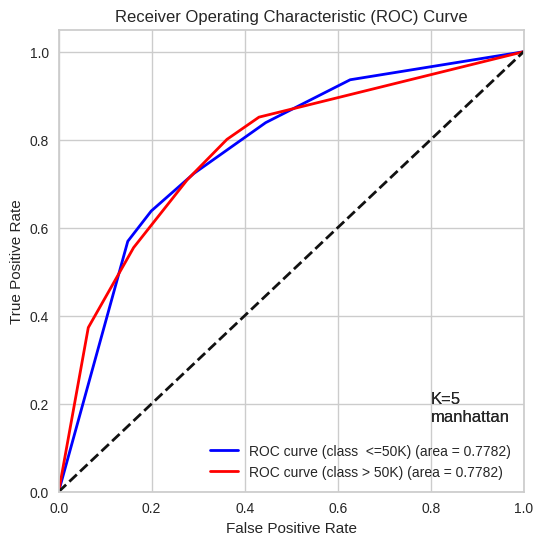

----------------------------------K=5 ------------------------------------------
****************minkowski***********************


KeyboardInterrupt: ignored

In [5]:

#Data Processing
#1. Data quality issue. Remove the "." from Income Class.
df["Income-Class"].replace({" <=50K.":" <=50K"," >50K.":" >50K"},inplace=True)
#2. Turn the sex into binary field
df["sex"].replace({" Male":0," Female":1},inplace=True)
print(df["sex"])
#3. Drop the catagorical field that cannot be converted into binary and perform a proper labeling
for i in cols_format:
  if cols_format[i] == "discrete" and i != 'Income-Class':
        df.drop(i, axis = 1, inplace=True)
print(df)

unique_classes = df['Income-Class'].unique()

sqrt_n = mt.floor(mt.sqrt(len(df))) - 0 if mt.sqrt(len(df))%2 > 0 else 1

# Fit the encoder on the categorical data and transform it
#one_hot_encoded_data = encoder.fit_transform(categorical_data)

# print(cols[:-1])

for label in cols[:-1]:
        if cols_format[label] in ['binary','cont']:
            for val in unique_classes:
                plt.hist(df[df["Income-Class"]==val][label],label=val,alpha=0.7)
            plt.ylabel("No of Adults")
            plt.xlabel(label)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()

# Split the dataset using ratio according to rule of thumb
# Split the data into training (80%) and the combined validation and test set
train, temp = train_test_split(df, train_size=0.8, random_state=42)
# Split the combined validation (10%) and test set (10%)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

#Do scaling for the train data only
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

def knn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, sqrt_n):
  k_values = [5,15,51,101,137,501,1000,sqrt_n] #K value in report
  #k_values = [137]

  for i, k in enumerate(k_values, 1): # return k in: [(1, 1), (2, 5), (3, 20)] #Highest AUC

      for distance in ["euclidean","manhattan","minkowski"]:
        # Create a KNN classifier with the current k value
        knn = KNeighborsClassifier(n_neighbors=k,metric=distance, p=3) # Help to test manhattan / euclidean
        print("----------------------------------K="f"{k} ------------------------------------------")
        print(f'****************{distance}***********************')
        knn.fit(X_train, y_train)

        # Valiadation data
        cv_scores = cross_val_score(knn, X_train, y_train, cv=5)

        # Evaluate the model on the validation set
        # Calculate and display the accuracy on the test set
        y_valid_pred = knn.predict(X_valid)
        valid_accuracy = accuracy_score(y_valid, y_valid_pred)
        print(f"Validation Set Accuracy:{valid_accuracy:.2f}")

        # Evaluate the model on the test set
        # Calculate and display the accuracy on the test set
        y_test_pred = knn.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Test Set Accuracy: {test_accuracy:.4f}")

        # Print cross-validation scores
        print("Cross-Validation Scores:", cv_scores)
        print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}" )

        # Classification Report for Validation Set
        print("Classification Report for Validation Set:")
        print(classification_report(y_valid, y_valid_pred))

        # Classification Report for Test Set
        print("Classification Report for Test Set:")
        print(classification_report(y_test, y_test_pred))

        #Confusion Matrix
        #==========================================================================
        print(f'****************Cufusion matrix of {k} for Validation Set***********************')
        confusion_matrix(knn,unique_classes,X_train, y_train,X_test, y_test)

        #Compute ROC curve and ROC area for each class
        #==========================================================================
        print(f'****************AUC of {k} for Validation Set***********************')
        roc_auc_graph(knn,unique_classes, X_valid, y_valid,k,distance)

        #Compute ROC curve and ROC area for each class
        #==========================================================================
        print(f'****************AUC of {k} for Testing Set***********************')
        roc_auc_graph(knn,unique_classes, X_test, y_test,k,distance)

def logreg_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
  # instantiate the model
  logreg = LogisticRegression(solver='liblinear', random_state=0)

  # fit the model
  logreg.fit(X_train, y_train)

  cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

  y_test_pred = logreg.predict(X_test)

  # Print cross-validation scores
  print("Cross-Validation Scores:", cv_scores)
  print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}" )

  y_valid_pred = logreg.predict(X_valid)
  valid_accuracy = accuracy_score(y_valid, y_valid_pred)

  print(f"Validation Set Accuracy:{valid_accuracy:.2f}")

  # Classification Report for Validation Set
  print("Classification Report for Validation Set:")
  print(classification_report(y_valid, y_valid_pred))

  print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_test_pred)))

  # Classification Report for Test Set
  print("Classification Report for Test Set:")
  print(classification_report(y_test, y_test_pred))

  #Confusion Matrix
  #==========================================================================
  print(f'****************Cufusion matrix of Logistic Regression for Validation Set***********************')
  confusion_matrix(logreg, unique_classes, X_train, y_train, X_test, y_test)

  #Compute ROC curve and ROC area for each class
  #==========================================================================
  print(f'****************AUC of Logistic Regression for Validation Set***********************')
  roc_auc_graph(logreg, unique_classes, X_valid, y_valid,"","")

  #Compute ROC curve and ROC area for each class
  #==========================================================================
  print(f'****************AUC of Logistic Regression for Testing Set***********************')
  roc_auc_graph(logreg, unique_classes, X_test, y_test,"","")

logreg_model(X_train, y_train, X_valid, y_valid, X_test, y_test)
knn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, sqrt_n)